In [1]:
import os
import math
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from coordinates import LocalCoord
import coordinates as coord

# Load data from files

In [2]:
# input_size = 39
input_size = 55 
PRN_size = 32
res_size = 1
label_size = 3

# Origin of NED coordinate system
# Latitude, Longitude, and Altitude
# # Rural area
# origin_ned = np.array([37.471338, -122.237757, 13])
# Urban area
origin_ned = np.array([37.334342, -121.887827, 24])
local_coord = LocalCoord(origin_ned, coord.geodetic2ecef(origin_ned))

# %% *********************************** Reading training data in multiple data files ***********************************
training_data_dir = "../data/Dynamic/Data4QE/RouteUS/Training/"
# Get all files in the current directory
training_data_files = os.listdir(training_data_dir)
inputs_list = []
labels_list = []
for data_file in training_data_files:
    # If the object is not a directory, we will open and read it
    data_file_path = training_data_dir+'/'+data_file
    if not os.path.isdir(data_file_path):
        # Read one data file
        data = pd.read_csv(data_file_path)
        
        # Input features: E, N, C/N0, Elevation
        # Convert Ground truth location from ECEF to NED
        NED = local_coord.ecef2ned(np.array(data.iloc[:, 10:13].values))
        inputs = np.concatenate([NED[:, 1::-1], np.array(data.iloc[:, 8:9].values), np.array(data.iloc[:, 6:7].values/math.pi*180)], axis =1)
        
        # Unsmoothed pseudorange residuals
        labels = np.array(data.iloc[:, 31:32].values)
        
        inputs_list.append(inputs)
        labels_list.append(labels)

InputsAll = np.concatenate(inputs_list, axis = 0) 
LabelsAll = np.ravel(np.concatenate(labels_list, axis = 0))
len(InputsAll), len(LabelsAll)       

(1773, 1773)

# Random Forest

In [ ]:
# Number of features randomly selected for node splitting 
s = 2

# Number of trees
m = 2000

# Maximum depth of trees
md = 20

# Ratio of samples for each tree
rSamples = 0.2

regr = RandomForestRegressor(n_estimators=m, max_depth=md, max_features=s, max_samples=rSamples)
regr.fit(InputsAll, LabelsAll)

# save the model to disk
filename = 'finalized_RF_model.sav'
pickle.dump(regr, open(filename, 'wb'))

# # K-fold cross validated grid-search for hyperparameter tweaking
# rfRegressor = RandomForestRegressor(n_estimators=m, max_features=s)
# parameters = {'max_depth':[3, 5, 7, 10, 20], 'max_samples':[0.1, 0.2, 0.3, 0.4, 0.5]}
# regr = GridSearchCV(rfRegressor, parameters, scoring='neg_mean_squared_error', cv=5)
# regr.fit(InputsAll, LabelsAll)

# # save the model to disk
# filename = 'finalized_RF_bestModel.sav'
# pickle.dump(regr.best_estimator_, open(filename, 'wb'))
# regr.best_params_


# Load the Best Model

In [2]:
# load the model from disk
filename_eval = 'finalized_RF_bestModel_urban.sav'
loaded_model = pickle.load(open(filename_eval, 'rb'))
loaded_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': 0.1,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Count the nodes in the RF

In [6]:
SumNode = 0
for eachTree in loaded_model.estimators_:
    SumNode = SumNode + eachTree.tree_.node_count
SumNode

394038

# Prediction

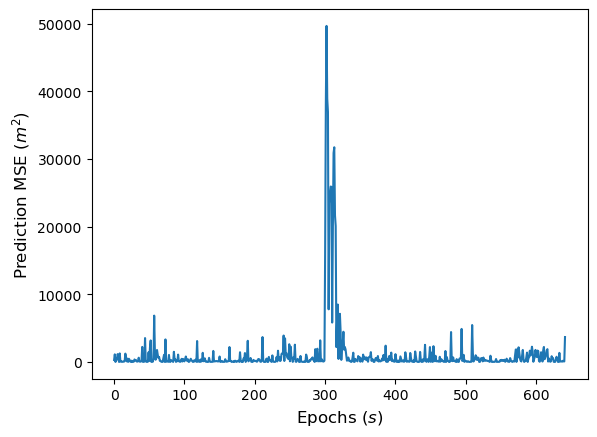

In [12]:
# %% *********************************** Reading testing data  ***********************************
data_file_eval = "../data/Dynamic/Data4QE/RouteUS/Testing/SvPVT3D_Error_label_dynamic_2021-04-28-US-SJC-1_G.csv"
data_eval = pd.read_csv(data_file_eval)

# Input features: E, N, C/N0, Elevation
# Convert Ground truth location from ECEF to NED
NED_eval = local_coord.ecef2ned(np.array(data_eval.iloc[:, 10:13].values))
inputs_eval = np.concatenate([NED_eval[:, 1::-1], np.array(data_eval.iloc[:, 8:9].values), np.array(data_eval.iloc[:, 6:7].values/math.pi*180)], axis =1)

# Unsmoothed pseudorange residuals
labels_eval = np.array(data_eval.iloc[:, 31:32].values)

# Prediction with RF
haty = loaded_model.predict(inputs_eval)

# Write debiased results to a .csv file
prm_bias_np = np.concatenate([np.array(data_eval.iloc[:, 0:2].values), np.expand_dims(haty, axis =1)], axis = 1)
prm_bias_np_df = pd.DataFrame(prm_bias_np)
prm_bias_np_df.to_csv('PrM_Bias_2021-04-28-US-SJC-1_RF_G.csv',header=False)

# plot
fig, ax = plt.subplots()
ax.plot((np.expand_dims(haty, axis =1)-labels_eval)**2)
ax.set_xlabel('Epochs ($s$)', fontsize=12)
ax.set_ylabel('Prediction MSE ($m^2$)', fontsize=12)
plt.show()